In [21]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_ollama import ChatOllama
from langchain_openai import AzureChatOpenAI
from templates import CartAbandonmentSurvey

In [22]:
import json
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPEN_AI_KEY"] = os.getenv("OPEN_AI_KEY")
os.environ["OPENAI_API_VERSION"] = os.getenv("OPENAI_API_VERSION")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

file_path = os.path.join( "surveys.json")  # Adjust path if needed


In [23]:
llm = ChatOllama(model="llama3.1:latest", temperature=0)
# llm = AzureChatOpenAI(model="gpt-4o", api_key=os.getenv("OPEN_AI_KEY"), api_version=os.getenv("OPENAI_API_VERSION"))

In [24]:
from typing_extensions import TypedDict, Union

class OverallState(TypedDict):
    query:str
    industry:str
    role:str
    channels:str
    name:str
    description:str
    survey: Union[CartAbandonmentSurvey, dict, None]

In [25]:
from pydantic import BaseModel, Field
from typing import List, Literal

class survey_metadata(BaseModel):
    industry: Literal["saas", "eCommerce", "other"] = Field(..., description="The industry the survey is for.")
    role: Literal["productManager", "marketing", "sales", "customerSuccess", "peopleManager"] = Field(..., description="The role of the person responsible for creating the survey.")
    channels: List[Literal["app", "website", "link"]] = Field(..., description="Where the survey will be distributed (can be multiple channels).")

find_survey_metadata_prompt = """
Analyze the given topic and determine the most relevant survey parameters.
Topic: {topic}

Return a JSON object with:
- "industry": Choose from ["saas", "eCommerce", "other"]
- "role": Choose from ["productManager", "marketing", "sales", "customerSuccess", "peopleManager"]
- "channels": A list of ["app", "website", "link"]
"""


def find_survey_metadata(state:OverallState):
    """find the survey metadata"""
    prompt  = find_survey_metadata_prompt.format(topic=state["query"])
    response = llm.with_structured_output(survey_metadata).invoke(prompt)

    return {"industry":response.industry,"role":response.role,"channels":response.channels, }


In [26]:
class survey_type(BaseModel):
    name:str
    description:str

survey_type_prompt = """
From the following surveys:  
{surveys}  

Choose the **one** survey that best matches this topic: **"{topic}"**.  
Return only the survey name and a short description.  
"""


def find_survey_type(state: OverallState):
    """Find survey type"""
    with open(file_path, "r") as f:
        surveys = json.load(f)

    industry = state["industry"]
    channels = state["channels"]
    role = state["role"]

    matching_surveys = [
        survey for survey in surveys
        if industry in survey["industry"] and role == survey["role"] and any(c in survey["channels"] for c in channels)
    ]

    # Handle case where no surveys match
    if not matching_surveys:
        return {"name": None, "description": "No matching survey found."}

    # ✅ Use a separate variable to avoid overwriting
    formatted_prompt = survey_type_prompt.format(topic=state["query"], surveys=matching_surveys)

    response = llm.with_structured_output(survey_type).invoke(formatted_prompt)

    return {"name": response.name, "description": response.description}
    

In [ ]:
generate_survey_prompt = """
You are an expert in survey design. Generate a well-structured survey based on the following details:

- **Survey Name:** {name}  
- **Description:** {description}  
- **Target Industry:** {industry}  
- **Target Audience Role:** {role}  
- **Distribution Channels:** {channels}  

Ensure that:
1. The survey aligns with the given industry and role.
2. The structure follows the appropriate survey model dynamically.
3. The output is formatted to match the expected schema.

Use the correct structured output model based on the context.
"""


def generate_survey(state:OverallState):
    """ generate survey """
    formatted_prompt = generate_survey_prompt.format(
        name=state["name"], 
        description=state["description"],
        industry=state["industry"], 
        role=state["role"], 
        channels=state["channels"])
    response = llm.with_structured_output(CartAbandonmentSurvey).invoke(formatted_prompt)
    print(response, "response")
    return {"survey":response.dict()}

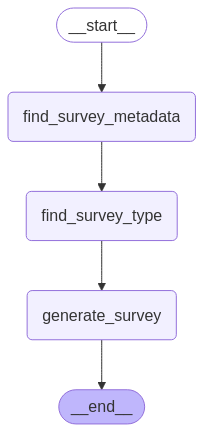

In [28]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
graph =  StateGraph(OverallState)


graph.add_node("find_survey_metadata", find_survey_metadata)
graph.add_node("find_survey_type", find_survey_type)
graph.add_node("generate_survey", generate_survey)

graph.add_edge(START, "find_survey_metadata")
graph.add_edge("find_survey_metadata", "find_survey_type")
graph.add_edge("find_survey_type", "generate_survey")
graph.add_edge("generate_survey", END)

graph = graph.compile()


display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [29]:
result  = graph.invoke({"query":"How can we reduce checkout abandonment ? "})
result

name='Rate Checkout Experience' role='productManager' industries=['eCommerce'] channels=['app', 'website'] description='Let customers rate the checkout experience to tweak conversion.' preset=SurveyPreset(name='Checkout Experience Survey', welcomeCard=None, endings=[{'type': 'rating', 'label': 'How would you rate your overall checkout experience?', 'options': ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']}, {'type': 'multiple-choice', 'label': 'What was the main reason for your rating?', 'options': ['Slow loading times', 'Difficulty with payment method', 'Unclear or confusing navigation', 'Other (please specify)']}, {'type': 'open-ended', 'label': 'Do you have any suggestions to improve our checkout process?'}, {'type': 'rating', 'label': 'How likely are you to make a repeat purchase from us?', 'options': ['Not at all likely', 'Somewhat unlikely', 'Neutral', 'Somewhat likely', 'Very likely']}], hiddenFields={'channel': 'app|website'}, questions=[SurveyQuestion(id='default_id', type

{'query': 'How can we reduce checkout abandonment ? ',
 'industry': 'eCommerce',
 'role': 'productManager',
 'channels': ['app', 'website'],
 'name': 'Rate Checkout Experience',
 'description': 'Let customers rate the checkout experience to tweak conversion.',
 'survey': CartAbandonmentSurvey(name='Rate Checkout Experience', role='productManager', industries=['eCommerce'], channels=['app', 'website'], description='Let customers rate the checkout experience to tweak conversion.', preset=SurveyPreset(name='Checkout Experience Survey', welcomeCard=None, endings=[{'type': 'rating', 'label': 'How would you rate your overall checkout experience?', 'options': ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']}, {'type': 'multiple-choice', 'label': 'What was the main reason for your rating?', 'options': ['Slow loading times', 'Difficulty with payment method', 'Unclear or confusing navigation', 'Other (please specify)']}, {'type': 'open-ended', 'label': 'Do you have any suggestions to improve o